In [62]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import os
import datetime
import subprocess
from mech_dot_inp_gen import *
import jinja2
import copy

In [63]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/szupernikusz/OptimaPP/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [64]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str,
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
        print((self.job_folder / f"mechTestResults_{input_mech}.csv"))
        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            print((self.job_folder / f"mechTestResults_{input_mech}.csv").exists())
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'],
                                        )#low_memory=False)
            #print(self.all_sheets_dP)
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

        stac_eq_df = pd.concat({k: v.iloc[-1] for k, v in self.all_data.items()}, axis=1)                # makes a dict() with the
        #followed18 = pd.concat({k: v.iloc[-1] for k, v in self.orig_time_sim_df.items()}, axis=1)        # same keys, the values are
        self.df_basal = stac_eq_df.iloc[3:-1].T                                                          # the last elements i.e.,
        #self.df_followed18 = followed18.T                                                                # t = last time_point

    def __str__(self):
        if not self.df_basal.empty and not self.df_followed18.empty:
            return f"Mech object was successfully generated with fields\ndf_basal: {self.df_basal.shape}\ndf_followed18: {self.df_followed18.shape}"
        elif self.df_basal.empty and not self.df_followed18.empty:
            return "Unsuccessful, error with df_basal"
        elif not self.df_basal.empty and self.df_followed18.empty:
            return "Unsuccessful, error with df_followed18"
        else:
            return "Mech object was not successfully created"

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df = {}
        self.orig_time_exp_df = {}

        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        self.failed_sims_xmls = []

        for _, row in all_sheets_dP.iterrows():
            if row.xml in self.failed_sims_xmls:
                continue

            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point += 1
            else:
                species = row.species
                time_point = 1

            if sim_val != 'FAILED':
                # ensure dict entries exist
                if xml_name not in self.orig_time_sim_df:
                    self.orig_time_sim_df[xml_name] = pd.DataFrame()
                if xml_name not in self.orig_time_exp_df:
                    self.orig_time_exp_df[xml_name] = pd.DataFrame()

                # ALWAYS assign (no else:)
                self.orig_time_sim_df[xml_name].loc[time_point, species] = float(sim_val)
                self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val
            else:
                self.failed_sims_xmls.append(xml_name)

        # make sure rows are in time order and numeric
        for xml, df in self.orig_time_sim_df.items():
            self.orig_time_sim_df[xml] = df.sort_index().apply(pd.to_numeric, errors='coerce')

        # build “followed18” as last valid values per species
        followed18 = pd.concat(
            {xml: df.ffill().iloc[-1]              # or: df.apply(lambda c: c.dropna().iloc[-1])
            for xml, df in self.orig_time_sim_df.items()},
            axis=1
        )
        self.df_followed18 = followed18.T


In [65]:
class Processing:
    def __init__(self, species_txt: str, ) -> None:
        self.species = self.get_species(species_txt)
        #self.observables, self.not_observables = self.get_observables()
        self.observables = ['RAP', 'MTORA', 'REF', 'RK', 'FKBP12',
                            'RKMTORA', 'RAPOUT', 'ULK', 'ULKA',
                            'AMPK', 'AMPKA', 'MTOR']
        self.not_observables = list(set(self.species) - set(self.observables))

    def get_species(self, species_txt: str) -> list[str]:
        species = []
        with open(species_txt, 'r') as f:
            lines = f.readlines()
        for line in lines:
            for s in line.strip().split():
                species.append(s)
        print(len(species), species)
        return species

    def get_observables(self) -> tuple[list[str], list[str]]:
        dont_observe = []
        for s in self.species:
            if s == 'Q' or 'LKB1' in s or 'PP2A' in s or 'GLUT1' in s or 'RAP' in s or 'RK' in s or s in ['RHEB', 'PYRUVATE', 'AKT', 'TSCA']:
                dont_observe.append(s)
            elif s == 'FKBP12' or s == 'REF':
                dont_observe.append(s)
        observe = list(set(self.species) - set(dont_observe))
        print(len(observe), observe)
        return observe, dont_observe

In [66]:
class Model:
    def __init__(self, model_name: str, ics_df_path, # data_source: a pandas DataFrame
                 dont_observe: list[str], time_points: list[float],
                 time_course_vals: Union[dict[str, list[float]], float],
                 food: str, must_be_zero: list[str]=[], uncertainty=False,
                 inputs: dict[str, float]={'GLUCOUT': 6e-6}): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.model_name = model_name
        self.ics_df = pd.read_csv(ics_df_path, sep=',')
        self.ics_df['minconc'] = self.ics_df['minconc'].astype(float)
        self.ics_df['maxconc'] = self.ics_df['maxconc'].astype(float)
        self.ics_df['value'] = self.ics_df['value'].astype(float)
        self.ics_df.species = [s.upper() for s in self.ics_df.species]
        self.species = self.ics_df['species'].to_list()
        self.output_species = list(set(self.species) - set(dont_observe))
        self.time_points = time_points
        if isinstance(time_course_vals, float):
            self.time_course_vals = self.gen_time_course_vals(time_course_vals)
        else:
            self.time_course_vals = time_course_vals
        self.food = food
        self.must_be_zero = must_be_zero
        self.uncertainty = uncertainty
        self.inputs = inputs

        self.ranges = self.get_bounds()
        print(f"range values stored in model.ranges of length {len(self.ranges.keys())}")
        self.get_sigmas()
        self.gen_exp_data()

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for _, row in self.ics_df.iterrows():
            if 'REF' not in row.species and row.species not in self.must_be_zero:
                if row.value < 1e-13:
                    lb = 1e-14
                    ub = 1e-13
                elif row.minconc == row.maxconc:
                    lb = row.minconc
                    ub = row.maxconc
                else:
                    if row.value/2 >= row.minconc:
                        lb = (row.value/2)
                    else:
                        lb = row.minconc
                    if row.value*1.5 <= row.maxconc:
                        ub = (row.value*1.5)
                    else:
                        ub = row.maxconc
            bounds[row.species.upper()] = [lb, ub]
        return bounds

    def get_sigmas(self):
        self.sigmas = dict()
        for key, value in self.ranges.items():
            if self.uncertainty:
                if key in self.must_be_zero: # this line might be unnecessary, as I think we need sigma only if the species is an output
                    self.sigmas[key] = 5e-18
                elif key in self.output_species:
                    if value[1] > value[0]:
                        self.sigmas[key] = ((value[1]-value[0])/8)
                    else:
                        self.sigmas[key] = 5e-13
            else:
                self.sigmas[key] = 2.5e-11

    def gen_time_course_vals(self, time_course_vals):
        species_time_course = {}
        for s in self.species:
            species_time_course[s] = np.ones(len(self.time_points)) * time_course_vals
        return species_time_course

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for s in self.output_species:
            self.exp_data[s] = self.ics_df[self.ics_df['species'] == s].iloc[0, 2] # "exp_data" = value of the csv column

In [67]:
class Genesis:
    def __init__(self, model: Model, max_digit = 4):
        self.model = model
        self.maxdigit = max_digit

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int,
                         xml_template_path: str, prefix: str='', kiir=True) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_xmls = num_of_xmls
        self.output_dir = output_xmls_path
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        if kiir:
            for i in range(1, num_of_xmls+1):
                np.random.seed(i+1)
                self.random_ics = self.get_random_ics()
                self.make_xml_output(i, output_xmls_path, prefix)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        if self.model.uncertainty:
            for key in self.model.species:
                if key not in self.model.must_be_zero:
                    random_ics[key] = np.random.uniform(*self.model.ranges[key])
                else:
                    random_ics[key] = 0
        else:
           random_ics = dict(zip(self.model.ics_df['species'], self.model.ics_df['value']))
        for key in self.model.inputs.keys():
            random_ics[key] = self.model.inputs[key]
        random_ics["REF"] = 1.0
        if self.model.food == 'stac':
            random_ics['Q'] = 6e-6
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str, prefix) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        output = self.template.render(ics=self.random_ics, relsigmas=self.model.sigmas,
                                      variables=self.model.output_species, dataPoints=dataPoints)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"{prefix}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

In [68]:
class Simulation:
    def __init__(self, gen: Genesis, xmls_in_one_opp: int) -> None:
      self.gen = gen
      self.get_xml_vec(xmls_in_one_opp)

    def get_xml_vec(self, xmls_in_one_opp) -> None:
      self.xmls = []
      for i in range(1, self.gen.num_xmls, xmls_in_one_opp):
          xml_cnt = np.arange(i, i+xmls_in_one_opp, 1) 
          self.xmls.append(xml_cnt)

    def opp_gen(self, opp_output_dir, opp_name_prefix, kiir, mech_file, food) -> None:
      self.opps = []
      self.indices = []
      self.food = food
      self.mech_file = mech_file
      self.mech_inp_name = self.mech_file.split('/')[-1].split('.inp')[0]
      for num in self.xmls:
          opp_filename = f"{opp_name_prefix}_{num[-1]}.opp"
          self.opps.append(opp_filename)
          self.indices.append(f"{num[-1]}")
          if kiir:
            opp_content = self.generate_opp_content(xml_folder=self.gen.output_dir,
                                                    num_xmls=num,
                                                    mech_file=mech_file,
                                                    name=self.food)
            with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
              f.write(opp_content)

    def generate_opp_content(self, xml_folder: str, num_xmls: Union[list[int], list[list[int]]],
                             mech_file: str, name: str, time_limit: int = 50, thread_limit: int = 32,
                             settings_tag: str = "systems_biology", solver: str = "cantera") -> str:
      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      yaml = mech_file.split('.inp')[0]

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver} {yaml}.yaml
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml in num_xmls:
          padded_number = str(xml).zfill(self.gen.maxdigit)
          mechtest += f"      NAME {xml_folder}/{name}_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def sim_runner(self, log_location:str = ''):
      self.parent_path = Path.cwd().parents[4] / "OptimaPP"

      if log_location == '':
        for idx, opp_file in enumerate(self.opps):
            command = ["bin/Release/OptimaPP", f"../Projects/Semmelweis_BCRN/BCRN/1_mechtest/{opp_file}"]
            print(f"Running: {' '.join(command)}")
            subprocess.run(command, check=True, cwd=self.parent_path)
      else:
        for idx, opp_file in enumerate(self.opps):
          command = ["bin/Release/OptimaPP", f"../Projects/Semmelweis_BCRN/BCRN/1_mechtest/{opp_file}"]
          print(f"Running: {' '.join(command)}")
          log_idx = self.xmls[idx][-1]
          with open(f"{log_location}/run_log_{self.food}_{log_idx}.txt", "w") as log:
              subprocess.run(command, check=True, stdout=log, stderr=subprocess.STDOUT, cwd=self.parent_path)

In [69]:
class Natural_Selection:
    def __init__(self, sim: Simulation) -> None:
        self.sim = sim
        self.sim_data: dict[str, OptimaMechtest] = {}
        self.get_sim_data()
        #self.survival_of_the_fittest()

    def get_sim_data(self) -> None:
        for idx, key in enumerate(self.sim.indices):
            self.sim_data[key] = OptimaMechtest(job_name=self.sim.opps[idx],
                                                input_mech=self.sim.mech_inp_name)

    def sigma_range(self, meas, sim, sigma):
        radius = (sim-meas)/sigma
        return radius
    
    def isit_init(self, row):
        lut = self.sim.gen.model.ics_df
        rel_sigmas = self.sim.gen.model.sigmas
        for k, v in row.items():
            if k in self.condition_vars:
                right_row = lut[lut['species'] == k]

                meas = right_row['value'].iloc[0]

                radius = self.sigma_range(meas=meas, sim=v, sigma=rel_sigmas[k])

                if radius >= 4:
                    self.wrongdoers[k] += 1
                    return False

        return True
    
    def survival_of_the_fittest(self) -> None:
        self.good_xmls = []
        self.get_condition_vars()
        self.wrongdoers = {k: 0 for k in self.condition_vars}
        for idx in self.sim.indices:
            for xml_name, row in self.sim_data[idx].df_followed18.iterrows():
                all_ok = self.isit_init(row)
                if all_ok:
                    self.good_xmls.append(xml_name)
        print(f"Found {len(self.good_xmls)} good xmls")

    def get_condition_vars(self) -> None:
        self.condition_vars = ['RHEBA', 'AKTA', 'TSC', 'MTORA', 'ATP', 'ULK', 'GLUCIN']
# too big LKB1 activity could mean upregged AMPK biologically speaking
# ADP, AMP make complexes just like ATP, but for AMP/ADP the complex concentrations are comparable to the
# cc. of either ADP or AMP --> complex-bound ADP/AMP would throw the calculation off
# LKB1 and PP2A form complexes with the AMPKs --> their cc. should change --> not adequate conditions
    def filtering(self) -> None:
        data = copy.deepcopy(self.sim_data)
        first = True
        self.filtered_basal = pd.DataFrame()
        self.filtered_followed = pd.DataFrame()
        for k, v in data.items():
            v.df_basal.index = v.df_basal.index.str[7:-9]
            v.df_basal = v.df_basal.sort_index()
            if first:
                self.filtered_basal = v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]
                self.filtered_followed = v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]
                first = False
            else:
                self.filtered_basal = pd.concat([self.filtered_basal, v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]],
                                        ignore_index=False)
                self.filtered_followed = pd.concat([self.filtered_followed, v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]],
                                            ignore_index=False)

    def get_cov_cor(self, corr_xmls, keys: list[str]) -> None:
        self.dict_b = {}
        self.dict_f = {}
        self.dict_b_corr = {}
        self.dict_f_corr = {}
        self.dict_b_cov = {}
        self.dict_f_cov = {}
        for idx, alma in enumerate(corr_xmls):
            self.dict_f[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy()
            #self.dict_b[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy()
            #self.dict_b_corr[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().corr()
            self.dict_f_corr[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().corr()
            self.dict_f_cov[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().cov()
            #self.dict_b_cov[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().cov()

In [79]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med  = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def _spread(y_values, min_gap):
    """
    Given a list of y positions, return adjusted positions so that
    consecutive labels are at least `min_gap` apart (in data units),
    while preserving ordering as much as possible.
    """
    y = np.array(y_values, dtype=float)
    order = np.argsort(y)
    y_sorted = y[order]

    adj = np.empty_like(y_sorted)
    prev = -np.inf
    for i, val in enumerate(y_sorted):
        if val <= prev + min_gap:
            adj[i] = prev + min_gap
        else:
            adj[i] = val
        prev = adj[i]

    result = np.empty_like(adj)
    result[order] = adj
    return result

def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- NEW: separate figures per species ----
    multi_fig: bool = False,
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a *list of figures*,
        one figure per species, using the chosen layout_mode.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- NEW: create one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,      # avoid infinite recursion
                )
            )
        return figs
    # --------------------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            ax.set_title(f"Time Profile of {sp} Dynamics for N = {Xa.shape[0]} Simulations", fontsize=20)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else: # stac vs starve
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label, bucket):
            first_for_stat = True
            sp_colors = {}

            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha, label='_nolegend_')

                if show_p80:
                    band = ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('P80', None)] = band
                if show_iqr:
                    band = ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('IQR', None)] = band

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                    sp_colors[sp] = line.get_color()
                    bucket[('mean', sp)] = line
                if show_median:
                    line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                    bucket[('median', sp)] = line

                first_for_stat = False

            if cond_label == 'RAP':
                ax.set_title(f"RAP Treated Dynamics for N = {X.shape[0]} simulations", fontsize=15)
            else:
                ax.set_title(f"Basal State Dynamics for N = {X.shape[0]} simulations", fontsize=15)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

            # left species labels
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                x_min, x_max = ax.get_xlim()
                ax.set_xlim(0, x_max)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=2.0, alpha=0.6, color=col,
                                label='_nolegend_',
                                clip_on=False)

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
                              samp_a, label_a, legend_data[label_a])
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
                              samp_b, label_b, legend_data[label_b])

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # --- NEW: force y-ticks/labels on the right subplot as well -----
        axes[1].tick_params(labelleft=True)
        # ----------------------------------------------------------------

    # -------- legend placement (same as your last version) -------------
    if layout_mode == "condition" and legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1
    else:
        if layout_mode == "condition":
            h0, l0 = axes[0].get_legend_handles_labels()
            h1, l1 = axes[1].get_legend_handles_labels()
            handles, labels = list(h0), list(l0)
            for h, lab in zip(h1, l1):
                if lab not in labels:
                    handles.append(h)
                    labels.append(lab)
        else:
            handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    #fig.subplots_adjust(left=0.22)
    return fig

In [19]:
# Read the input file
with open("../input_files/species_rap.txt", "r") as f:
    text = f.read()

# Split on any whitespace and create a set
species_set = set(text.split())

# (Optional) sort for nicer output
unique_species = sorted(species_set)

# Print results
print(f"Number of unique species: {len(unique_species)}")

# (Optional) save to a file
with open("../input_files/unique_species_rap.txt", "w") as f:
    for s in unique_species:
        f.write(s + "\n")


Number of unique species: 87


In [20]:
write_inp(list(species_set), out_path='../../mech/dummy.inp')

In [71]:
proc = Processing('../input_files/unique_species_rap.txt')
print(len(proc.observables), proc.observables)

87 ['AC', 'AC_GA', 'AC_GAA', 'AKT', 'AKTA', 'AMPK', 'AMPKA', 'ATG5', 'ATG5T', 'ATG5_BCL2', 'AUT', 'BAX', 'BAXA', 'BCL2', 'BCL2_BAX', 'BCL2_PUMA', 'BEC1', 'BEC1A', 'BEC1_BCL2', 'BEC1_UVG', 'BID', 'CA2ER', 'CA2IC', 'CALPAIN', 'CALPAINA', 'CAMKKB', 'CAMKKBA', 'CAMP', 'CASP', 'CCH', 'CYTC', 'CYTCM', 'DAPK', 'DAPKA', 'DRAM', 'DS', 'EPAC', 'EPACA', 'FKBP12', 'GA', 'GAA', 'GABC', 'GBC', 'GPCRA', 'INSULIN', 'IP3', 'IP3R', 'IP3R_BCL2', 'IP3R_IP3', 'MDM2', 'MTOR', 'MTORA', 'NS', 'P53', 'P53A', 'P53A_BCL2', 'PHAG', 'PI3K', 'PI3KA', 'PIP2', 'PKA', 'PKAA', 'PKC', 'PKC_CA2IC', 'PLCE', 'PLCEA', 'PREAUT', 'PROCASP', 'PUMA', 'RAP', 'RAPOUT', 'REF', 'RHEB', 'RHEBA', 'RK', 'RKMTORA', 'SERCA', 'SERCAA', 'TBID', 'TG', 'TG_SERCA', 'TSC', 'TSCA', 'ULK', 'ULKA', 'UVG', 'UVG_BAX']
12 ['RAP', 'MTORA', 'REF', 'RK', 'FKBP12', 'RKMTORA', 'RAPOUT', 'ULK', 'ULKA', 'AMPK', 'AMPKA', 'MTOR']


In [72]:
gluc_rap = pd.read_csv('../input_files/gluc_rap_ranges.csv')
combined = pd.read_csv('../input_files/combined_ranges.csv')

cols = ["minconc", "maxconc", "value"]
combined[cols] *= 1e-12

for idx, row in combined.iterrows():
    sp = row['species']
    if sp.upper() not in proc.species:
        print(f"Removing {sp}")
        combined.drop(idx, inplace=True)

combined.to_csv('../input_files/rap_ranges_scaled.csv', index=False)

Removing PYRUVATE
Removing Q
Removing ATP
Removing ADP
Removing AMP
Removing AMPK_ATP
Removing AMPK_ADP
Removing AMPK_AMP
Removing AMPKA_ATP
Removing AMPKA_ADP
Removing AMPKA_AMP
Removing AMPK_LKB1
Removing AMPK_ATP_LKB1
Removing AMPK_ADP_LKB1
Removing AMPK_AMP_LKB1
Removing AMPKA_PP2A
Removing AMPKA_ATP_PP2A
Removing AMPKA_ADP_PP2A
Removing AMPKA_AMP_PP2A
Removing LKB1
Removing PP2A
Removing GLUT1
Removing GLUCOUT
Removing GLUCIN
Removing GLUT1_GLUCOUT
Removing GLUT1_GLUCIN


In [77]:
exp_foods = ['rap', 'no_rap']
must_be_zero = ['RAP', 'RK', 'RKMTORA']
date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"
t = np.arange(0, 5070, 30)
sims: dict[str, Simulation] = {}

for food in exp_foods:
    if food == 'rap':
        exp_food = 1e-10
    elif food == 'no_rap':
        exp_food = 0.0
    else:
        raise Exception('food must either be "rap" or "no_rap"')

    mod = Model(model_name='rap_big', ics_df_path='../input_files/rap_ranges_scaled.csv',
                dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
                uncertainty=True, must_be_zero=must_be_zero, inputs={'RAPOUT': exp_food},
                food=food)

    gen = Genesis(mod, max_digit=4)
    gen.create_xml_files(output_xmls_path=f'/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/xml/testing_rap_big_{food}',
                         num_of_xmls=100,
                         xml_template_path='../input_files/std_xml_template.xml',
                         prefix=food, kiir=True)

    sim = Simulation(gen, 100)
    sim.opp_gen(opp_output_dir='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/1_mechtest',
                opp_name_prefix=f'{date_prefix}_testing_rap_big_{food}',
                kiir=True, mech_file='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/mech/rap_big.inp',
                food=food)

    sim.sim_runner('/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/logs/testing_rap_big')

    sims[food] = sim

range values stored in model.ranges of length 77
Running: bin/Release/OptimaPP ../Projects/Semmelweis_BCRN/BCRN/1_mechtest/2026128_testing_rap_big_rap_100.opp
range values stored in model.ranges of length 77
Running: bin/Release/OptimaPP ../Projects/Semmelweis_BCRN/BCRN/1_mechtest/2026128_testing_rap_big_no_rap_100.opp


In [78]:
mechs: dict[str, OptimaMechtest] = {}
for k in sims.keys():
    mechs[k] = OptimaMechtest(sims[k].opps[0], sims[k].mech_inp_name)

/home/szupernikusz/OptimaPP/outputs/2026128_testing_rap_big_rap_100.opp/mechTestResults_rap_big.csv
True
/home/szupernikusz/OptimaPP/outputs/2026128_testing_rap_big_no_rap_100.opp/mechTestResults_rap_big.csv
True


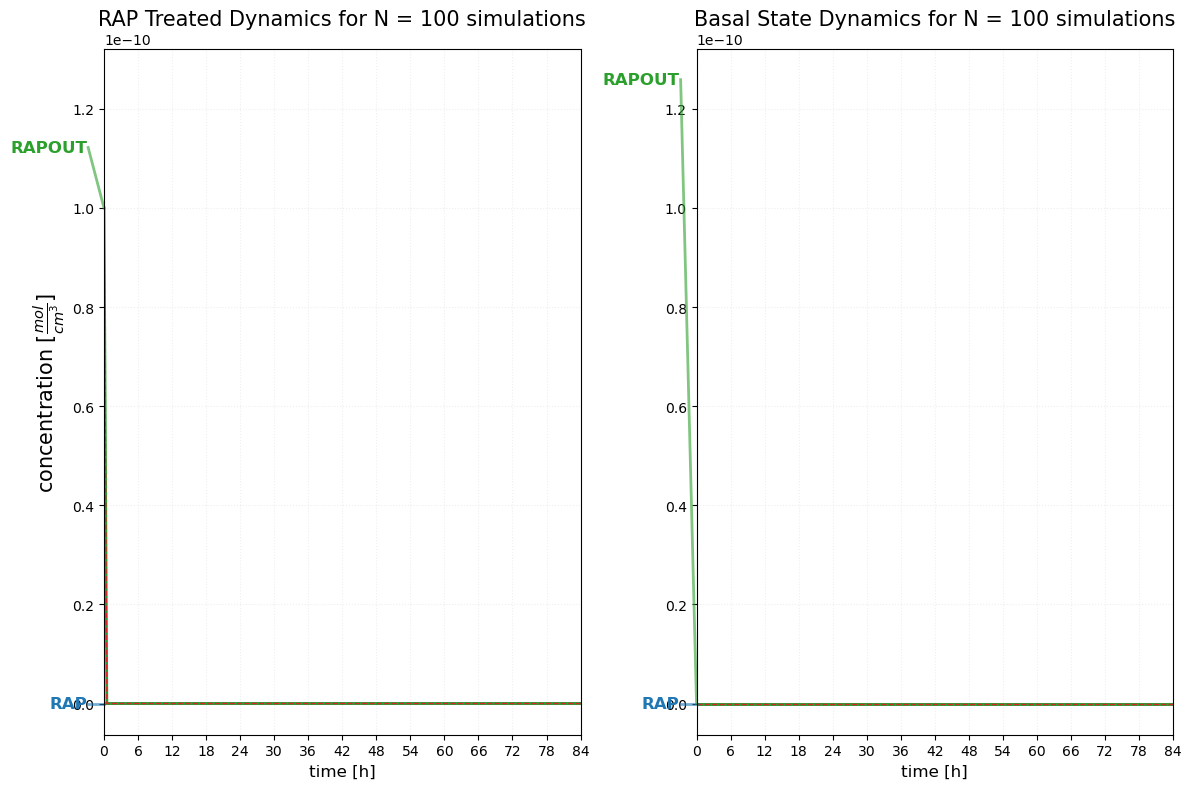

In [87]:
# Compare rap vs no-rap time courses in the same style as Starve_rap_combined
fig = plot_compare_summary(
    df_dict_a=mechs['rap'].orig_time_sim_df,
    df_dict_b=mechs['no_rap'].orig_time_sim_df,
    label_a='RAP', label_b='NO RAP',
    species=('RAP', 'RAPOUT'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100,
    legend_pos="none",
    curve_labels=True,
    curve_label_min_gap_frac=1.02,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 8),
)

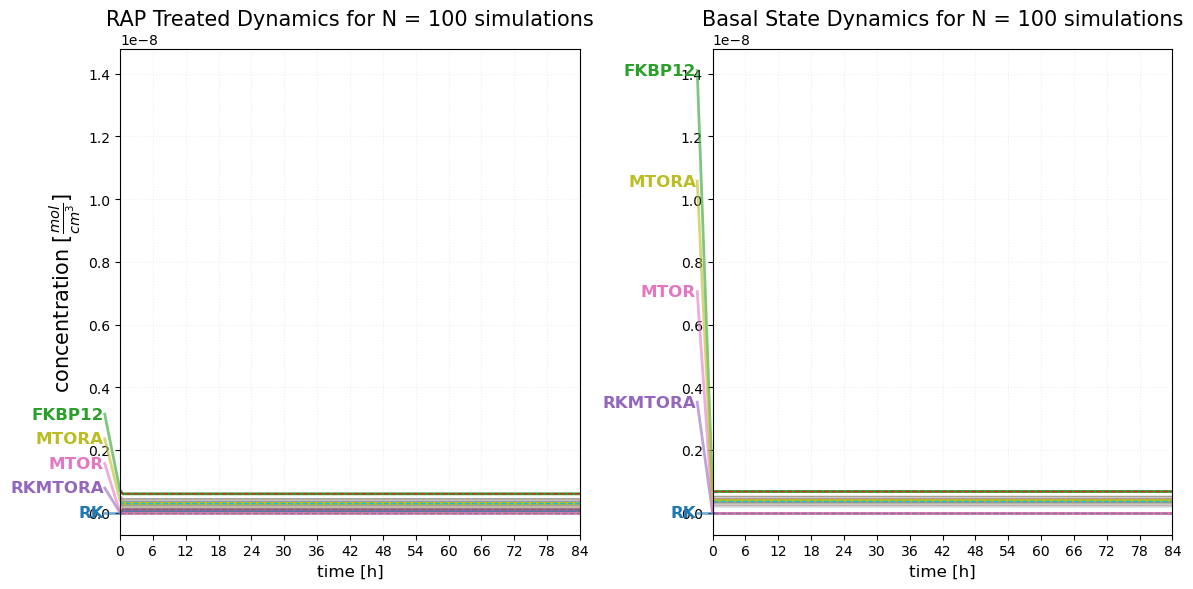

In [88]:
fig = plot_compare_summary(
    df_dict_a=mechs['rap'].orig_time_sim_df,
    df_dict_b=mechs['no_rap'].orig_time_sim_df,
    label_a='RAP', label_b='NO RAP',
    species=('RK', 'FKBP12', 'RKMTORA', 'MTOR', 'MTORA'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100,
    legend_pos="none",
    curve_labels=True,
    curve_label_min_gap_frac=1.02,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 6),
)

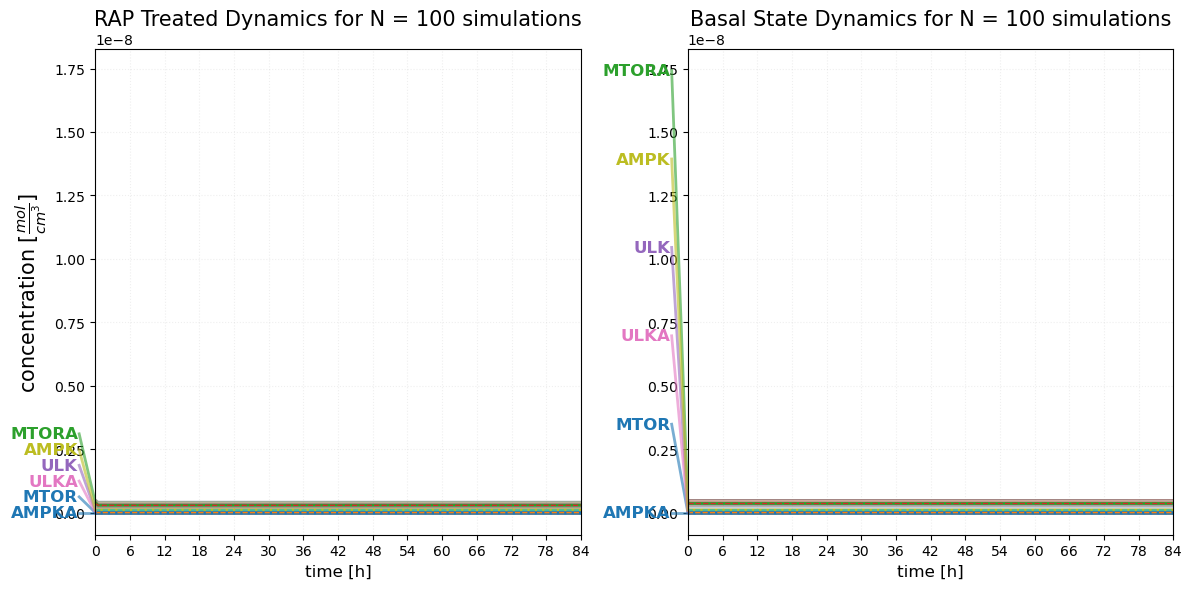

In [89]:
fig = plot_compare_summary(
    df_dict_a=mechs['rap'].orig_time_sim_df,
    df_dict_b=mechs['no_rap'].orig_time_sim_df,
    label_a='RAP', label_b='NO RAP',
    species=('MTOR', 'MTORA', 'ULK', 'ULKA', 'AMPK', 'AMPKA'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100,
    legend_pos="none",
    curve_labels=True,
    curve_label_min_gap_frac=1.02,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 6),
)
